# Задание ZALA  
## 2. Детектирование множества объектов

__YOLOv8n__ (Ultralytics YOLOv8 Nano) – самый лёгкий вариант, быстрый.  

__MobileNetV3-SSD__ – лёгкая модель для детекции. 

__EfficientDet-D0__ – баланс качества и скорости. 

__NanoDet / PP-YOLOE-S__ – быстрые и эффективные.  

## Импорты

In [49]:
import time
import xml.etree.ElementTree as ET  
import numpy as np
import os
import glob
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms


import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.ops import box_iou
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")


print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/devsTraining/zala_task


In [2]:
# устанавливаем device если gpu или cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.6.0+cu124
версия  cuDNN:           90100
Tue Apr  1 17:58:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8             22W /  170W |     494MiB /  12288MiB |     37%      Default |
|                                         

## Обработка данных

In [3]:
current_directory = os.getcwd()  

target = 'dataset/dataset_mobileNet/target/'    
output_labels_path = os.path.join(current_directory, target)  

image = 'dataset/dataset_mobileNet/image/'    
output_images_path = os.path.join(current_directory, image)  


# Путь к изображениям и аннотациям YOLO

labels = "dataset/dataset1/2_datasets_full_yolo/labels/train/"
labels_path = os.path.join(current_directory, labels)  
images = "dataset/dataset1/2_datasets_full_yolo/images/train/"
images_path = os.path.join(current_directory, images)  


print(labels_path)
print(images_path)


/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset1/2_datasets_full_yolo/labels/train/
/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset1/2_datasets_full_yolo/images/train/


In [ ]:
import os
import glob
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_labels_path, exist_ok=True)



class YoloToDetectionDataset(Dataset):
    def __init__(self, images_path, labels_path, output_images_path, output_labels_path, transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.output_images_path = output_images_path
        self.output_labels_path = output_labels_path
        self.transform = transform
        self.image_files = glob.glob(os.path.join(images_path, "*.jpg"))
        
        # Обновляем путь к меткам с учётом новых имен файлов
        self.label_files = [os.path.join(labels_path, os.path.splitext(os.path.basename(f))[0] + ".txt") for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Загрузка изображения
        img_path = self.image_files[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Загрузка аннотаций YOLO
        label_path = self.label_files[idx]
        bboxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])

                    # Если класс 0, заменяем на 10
                    if class_id == 0:
                        class_id = 10

                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Преобразование координат YOLO в абсолютные значения (в пикселях)
                    x_min = int((x_center - width / 2) * w)
                    y_min = int((y_center - height / 2) * h)
                    x_max = int((x_center + width / 2) * w)
                    y_max = int((y_center + height / 2) * h)
                    
                    bboxes.append([x_min, y_min, x_max, y_max])
                    labels.append(class_id)

        # Применяем трансформации, если указано
        if self.transform:
            img = self.transform(img)

        # Сохранение изображений на диск
        new_img_name = os.path.basename(img_path)
        new_img_path = os.path.join(self.output_images_path, new_img_name)
        
        # Преобразование тензора обратно в numpy перед сохранением
        img = img.permute(1, 2, 0).numpy()  # Меняем оси (C, H, W) -> (H, W, C)
        cv2.imwrite(new_img_path, cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        # Сохранение аннотаций на диск
        new_label_name = os.path.basename(label_path)
        new_label_path = os.path.join(self.output_labels_path, new_label_name)
        
        with open(new_label_path, "w") as f:
            for bbox, label in zip(bboxes, labels):
                # Записываем данные в формат YOLO
                x_center = (bbox[0] + bbox[2]) / 2 / w
                y_center = (bbox[1] + bbox[3]) / 2 / h
                width = (bbox[2] - bbox[0]) / w
                height = (bbox[3] - bbox[1]) / h
                f.write(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        return img, {'boxes': torch.tensor(bboxes), 'labels': torch.tensor(labels)}

# Применяем трансформации
transform = transforms.Compose([
    transforms.ToTensor(),
])







# # Создаем датасет
# dataset = YoloToDetectionDataset(images_path, labels_path, output_images_path, output_labels_path, transform)

# # Сохраняем данные
# for idx in range(len(dataset)):
#     img, target = dataset[idx]

# print(f"Датасет сохранён")


Датасет сохранён


In [6]:
class CustomDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.image_files = glob.glob(os.path.join(images_path, "*.jpg"))
        self.label_files = [
            os.path.join(labels_path, os.path.splitext(os.path.basename(f))[0] + ".txt")
            for f in self.image_files
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label_path = self.label_files[idx]

        # Загружаем изображение
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV читает в BGR, а нам нужен RGB
        img = cv2.resize(img, (512, 512))  # Приводим к нужному размеру
        
        # Загружаем аннотации
        boxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])  # Первый элемент — класс объекта
                    x, y, w, h = map(float, parts[1:])  # Координаты YOLO (нормализованные)
                    
                    # Преобразуем в формат (xmin, ymin, xmax, ymax)
                    xmin = (x - w / 2) * 512
                    ymin = (y - h / 2) * 512
                    xmax = (x + w / 2) * 512
                    ymax = (y + h / 2) * 512
                    
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(class_id)

        # Конвертируем в тензоры
        img = torch.tensor(img).permute(2, 0, 1) / 255.0  # (H, W, C) -> (C, H, W) + нормализация
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        return img, {"boxes": boxes, "labels": labels}

# Пути к данным
labels_path = output_labels_path
images_path = output_images_path

# Создаем dataset и dataloader
dataset = CustomDataset(images_path, labels_path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Проверяем работу DataLoader
for batch in dataloader:
    imgs, targets = batch
    print("Batch size:", len(imgs))
    print("Image shape:", imgs[0].shape)
    print("First target:", targets[0])
    break  # Останавливаем после первого батча


Batch size: 8
Image shape: torch.Size([3, 512, 512])
First target: {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


torch.Size([3, 512, 512])
Type of images: <class 'torch.Tensor'>


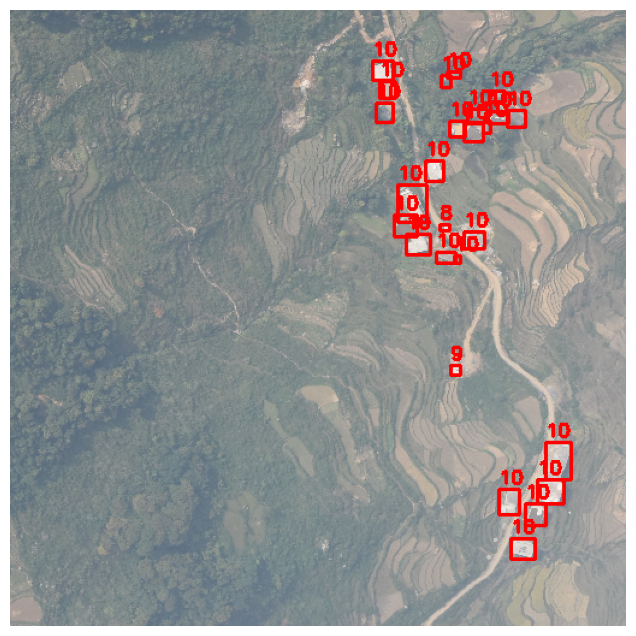

In [8]:
import torch
import cv2
import matplotlib.pyplot as plt

# Функция для отрисовки боксов
def visualize_batch(images, targets, class_names=None):
    batch_size = len(images)

    for i in range(batch_size):
        image = images[i].permute(1, 2, 0).numpy()  # Меняем порядок осей и конвертируем в numpy
        h, w, _ = image.shape

        # Переводим из тензора в список
        boxes = targets[i]["boxes"].cpu().numpy()
        labels = targets[i]["labels"].cpu().numpy()

        # Отрисовка боксов
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            
            # Подпись класса, если есть словарь классов
            class_name = class_names[label] if class_names else str(label)
            cv2.putText(image, class_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Показываем изображение
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis("off")
        plt.show()


data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# Загружаем первую пачку изображений
dataiter = iter(data_loader)
images, targets = next(dataiter)
print(images[0].shape)
# Визуализируем
print(f"Type of images: {type(images[0])}")
visualize_batch(images, targets)


## Модель

In [9]:
# Модель
import torch
import torch.nn as nn
import torch.nn.functional as F

# Блок Conv-BatchNorm-ReLU
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

# Inverted Residual Block (основа MobileNet)
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_dim = round(in_channels * expand_ratio)
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(in_channels, hidden_dim, kernel_size=1))
        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

# Основная модель MobileNet + SSD
class MobileNet_SSD(nn.Module):
    def __init__(self, num_classes=21, width_mult=1.0):
        super(MobileNet_SSD, self).__init__()
        input_channel = 32
        last_channel = 960
        
        # Определение архитектуры
        inverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # Блоки MobileNetV3
        features = [ConvBNReLU(3, input_channel, stride=2)]
        for t, c, n, s in inverted_residual_setting:
            output_channel = round(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        features.append(ConvBNReLU(input_channel, last_channel, kernel_size=1))
        self.features = nn.Sequential(*features)

        # SSD головы для предсказания боксов и классов
        self.loc_head = nn.Conv2d(last_channel, num_classes * 4, kernel_size=3, padding=1)
        self.cls_head = nn.Conv2d(last_channel, num_classes, kernel_size=3, padding=1)

        # Upsample блоки для разного масштаба
        self.upsample_1 = nn.ConvTranspose2d(960, 480, 2, stride=2)
        self.upsample_2 = nn.ConvTranspose2d(480, 240, 2, stride=2, padding=0)
        self.upsample_3 = nn.ConvTranspose2d(240, 64, 4, stride=2, padding=1)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)

        locs = self.loc_head(x)  # Координаты боксов
        confs = self.cls_head(x)  # Классы

        x = self.upsample_1(x)
        x = self.upsample_2(x)
        x = self.upsample_3(x)

        return locs, confs

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)














## Вспомогательные функции

In [ ]:

def get_grid_labels(image_size, annotations, grid_size=(16, 16)):
    """
    Преобразует аннотации объектов в метки для каждой ячейки на сетке.
    """
    # Разделяем изображение на сетку grid_size
    grid_height, grid_width = grid_size
    img_height, img_width = image_size

    # Инициализация меток для сетки (все ячейки = 0, что означает фон)
    labels = torch.zeros((grid_height, grid_width), dtype=torch.long)



    for annotation in annotations:
        print(annotation)
        boxes = annotation['boxes']  # [x_min, y_min, x_max, y_max]
        labels_tensor = annotation['labels']

        for i in range(boxes.shape[0]):
            box = boxes[i].cpu().numpy()
            label = labels_tensor[i].item()

            # Находим индекс ячейки для каждого объекта
            x_min, y_min, x_max, y_max = box

            # Для каждого объекта вычисляем ячейку (x, y)
            # Преобразуем координаты в индексы сетки (ячейки)
            grid_x_min = int(x_min // (img_width / grid_width))
            grid_y_min = int(y_min // (img_height / grid_height))

            grid_x_max = int(x_max // (img_width / grid_width))
            grid_y_max = int(y_max // (img_height / grid_height))

            # Заполняем соответствующие ячейки метками
            for y in range(grid_y_min, grid_y_max + 1):
                for x in range(grid_x_min, grid_x_max + 1):
                    labels[y, x] = label
            print(labels)
    return labels



# def get_grid_labels(image_size, annotations, grid_size):
#     """
#         Преобразует аннотации объектов в метки для каждой ячейки на сетке.
#     """
#     img_width, img_height = image_size
#     grid_width, grid_height = grid_size

#     # Создаем пустую метку для сетки (каждому элементу присваиваем 0)
#     grid_labels = torch.zeros((grid_height, grid_width), dtype=torch.long)

#     # Координаты ячеек для локализационных предсказаний
#     grid_locs = torch.zeros((grid_height, grid_width, 4), dtype=torch.float)  # 4 координаты (x_min, y_min, x_max, y_max)

#     boxes = annotations['boxes']
#     labels_tensor = annotations['labels']

#     for i in range(boxes.shape[0]):
#         box = boxes[i]
#         class_id = labels_tensor[i]

#         x_min, y_min, x_max, y_max = box

#         grid_x_min = int(x_min / img_width * grid_width)
#         grid_y_min = int(y_min / img_height * grid_height)
#         grid_x_max = int(x_max / img_width * grid_width)
#         grid_y_max = int(y_max / img_height * grid_height)

#         grid_labels[grid_y_min:grid_y_max + 1, grid_x_min:grid_x_max + 1] = class_id

#         # Сохраняем координаты бокса в формате [x_min, y_min, x_max, y_max]
#         grid_locs[grid_y_min:grid_y_max + 1, grid_x_min:grid_x_max + 1] = torch.tensor([x_min, y_min, x_max, y_max])

#     return grid_labels, grid_locs





def get_grid_labels(image_size, annotations, grid_size):
    """
    Преобразует аннотации объектов в метки для каждой ячейки на сетке.
    Здесь мы используем -1 для фона, и реальные метки для объектов.
    """
    img_width, img_height = image_size
    grid_width, grid_height = grid_size

    # Создаем пустую метку для сетки (фон = 0)
    grid_labels = torch.zeros((grid_height, grid_width), dtype=torch.long)

    # Координаты ячеек для локализационных предсказаний
    grid_locs = torch.zeros((grid_height, grid_width, 4), dtype=torch.float)  # 4 координаты (x_min, y_min, x_max, y_max)

    boxes = annotations['boxes']
    labels_tensor = annotations['labels']

    for i in range(boxes.shape[0]):
        box = boxes[i]
        class_id = labels_tensor[i]

        x_min, y_min, x_max, y_max = box

        grid_x_min = int(x_min / img_width * grid_width)
        grid_y_min = int(y_min / img_height * grid_height)
        grid_x_max = int(x_max / img_width * grid_width)
        grid_y_max = int(y_max / img_height * grid_height)

        # Присваиваем метку объекта на всех ячейках, которые пересекает его бокс
        grid_labels[grid_y_min:grid_y_max + 1, grid_x_min:grid_x_max + 1] = class_id

        # Сохраняем координаты бокса в формате [x_min, y_min, x_max, y_max] для ячеек сетки
        grid_locs[grid_y_min:grid_y_max + 1, grid_x_min:grid_x_max + 1] = torch.tensor([x_min, y_min, x_max, y_max])

    return grid_labels, grid_locs











def localization_loss(pred_locs, true_locs, true_labels):
    """
    Вычисление функции потерь для локализации объектов.
    
    pred_locs: Тензор предсказанных координат (locs) размером (batch_size * 512, 4)
    true_locs: Тензор истинных координат объектов размером (batch_size * 512, 4)
    true_labels: Тензор меток классов (batch_size * 512), для которых координаты актуальны.
    
    Возвращает: loss, сглаженная L1 потеря.
    """
    # Применяем Smooth L1 Loss только для тех ячеек, которые содержат объекты (для которых true_labels не равны 0)
    mask = true_labels > 0  # Маска, где true_labels больше 0 (то есть объект есть)
    
    # Получаем локализационные потери только для позиций, где есть объекты
    pred_locs = pred_locs[mask]
    true_locs = true_locs[mask]
    
    # Вычисляем Smooth L1 Loss (она схожа с L2 для малых ошибок и с L1 для больших)
    loss = F.smooth_l1_loss(pred_locs, true_locs, reduction='sum')
    
    # Возвращаем потерю
    return loss





def calculate_iou(pred_boxes, true_boxes, true_labels, IMAGE_SIZE=512):
    """
    Вычисление IoU (Intersection over Union) для предсказанных и истинных боксов.
    Мы считаем все объекты, включая те, у которых метка 0.
    """
    # Маска для объектов
    mask = true_labels > 0  

    # Обрезаем координаты
    pred_boxes = clip_boxes(pred_boxes, IMAGE_SIZE)
    true_boxes = clip_boxes(true_boxes, IMAGE_SIZE)
    
    # Нормализуем координаты
    pred_boxes = normalize_boxes(pred_boxes, IMAGE_SIZE)
    true_boxes = normalize_boxes(true_boxes, IMAGE_SIZE)

    # Применяем маску, чтобы взять только объекты
    pred_boxes = pred_boxes[mask]
    true_boxes = true_boxes[mask]

    # Если нет объектов, то просто вернуть 0 (для предотвращения деления на ноль)
    if len(pred_boxes) == 0 or len(true_boxes) == 0:
        return 0

    # Вычисляем пересечение
    x1 = torch.max(pred_boxes[:, 0], true_boxes[:, 0])
    y1 = torch.max(pred_boxes[:, 1], true_boxes[:, 1])
    x2 = torch.min(pred_boxes[:, 2], true_boxes[:, 2])
    y2 = torch.min(pred_boxes[:, 3], true_boxes[:, 3])

    # Вычисляем площадь пересечения
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Площадь предсказанных и истинных боксов
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    true_area = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])

    # Вычисляем объединение
    union = pred_area + true_area - intersection
    iou = intersection / (union + 1e-6)

    return iou.mean().item()  # Возвращаем средний IoU


def clip_boxes(boxes, IMAGE_SIZE=512):
    """
    Ограничивает координаты боксов так, чтобы они оставались в пределах изображения.
    """
    boxes[:, 0] = torch.clamp(boxes[:, 0], min=0, max=IMAGE_SIZE)  # x_min
    boxes[:, 1] = torch.clamp(boxes[:, 1], min=0, max=IMAGE_SIZE)  # y_min
    boxes[:, 2] = torch.clamp(boxes[:, 2], min=0, max=IMAGE_SIZE)  # x_max
    boxes[:, 3] = torch.clamp(boxes[:, 3], min=0, max=IMAGE_SIZE)  # y_max
    return boxes

def normalize_boxes(boxes, IMAGE_SIZE=512):
    """Приводит координаты к диапазону [0,1]"""
    return boxes / IMAGE_SIZE








## Обучение

In [19]:
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
dataiter = iter(data_loader)
images, targets = next(dataiter)
print(images[0].shape)


torch.Size([3, 512, 512])


### Обучение с классификацией объектов по разбитым ячейкам  без координат боксов

In [23]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создаем модель
num_classes = 11
model = MobileNet_SSD(num_classes=num_classes).to(device)

# Оптимизатор
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005)

# Функция потерь (MultiBox Loss)
criterion = nn.CrossEntropyLoss()

def train():
    # Пример обучающего цикла

    # images: батч изображений
    # targets: батч аннотаций
    for images, targets in data_loader:
        # Передаем данные на устройство
        # images = [img.to(device) for img in images]
        images = torch.stack(images).to(device) 

    
        # Инициализация меток для всех изображений в батче
        batch_labels = []
        for target in targets:

            # Преобразуем аннотации в метки сетки 16x16
            labels, grid_locs = get_grid_labels(image_size=(256, 256), annotations=target, grid_size=(16, 16))
            batch_labels.append(labels)

        # Теперь у нас есть метки для каждой картинки в батче
        batch_labels = torch.stack(batch_labels).to(device)  # Преобразуем в батч

        # Обработка изображения через модель
        model.train()
        optimizer.zero_grad()


        # Получаем предсказания (например, locs и confs)
        locs, confs = model(images)


        # Вычисляем функцию потерь
        # Преобразуем confs в нужный формат для CrossEntropy (2D -> 1D)
        confs = confs.view(-1, num_classes)  # Приводим к нужной форме

        # Применяем cross-entropy для предсказанных классов и меток
        loss = F.cross_entropy(confs, batch_labels.view(-1))  # Используем flatten метки

        # Вычисляем градиенты и обновляем параметры модели
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")
# train()

Loss: 12.410889625549316
Loss: 11.171463966369629
Loss: 11.353727340698242
Loss: 10.52863597869873
Loss: 10.648026466369629
Loss: 10.479588508605957
Loss: 10.120454788208008
Loss: 9.604021072387695
Loss: 9.53078842163086
Loss: 9.602499008178711
Loss: 9.598551750183105
Loss: 8.45959758758545
Loss: 9.08106803894043
Loss: 8.489962577819824
Loss: 8.343698501586914
Loss: 8.31801700592041
Loss: 7.934263229370117
Loss: 8.380133628845215
Loss: 7.725378036499023
Loss: 7.368046283721924
Loss: 7.367634296417236
Loss: 6.603525161743164
Loss: 6.578139305114746
Loss: 6.845378398895264
Loss: 6.303968906402588
Loss: 5.77004337310791
Loss: 5.32795524597168
Loss: 5.4712066650390625
Loss: 5.2638421058654785
Loss: 5.232895851135254
Loss: 5.03538703918457
Loss: 4.532782077789307
Loss: 4.501089572906494
Loss: 4.576242446899414
Loss: 4.315651893615723
Loss: 3.962514877319336
Loss: 4.063332557678223
Loss: 3.9385786056518555
Loss: 3.740382671356201
Loss: 3.3674824237823486
Loss: 3.6362104415893555
Loss: 3.3138

### Обучение с классификацией и локализацией  

 loss = loss_classification + lambda_loc * loss_localization

In [50]:
dataset = CustomDataset(images_path, labels_path)

# Разделяем на train (80%) и val (20%)
train_size = int(0.8 * len(dataset))  
val_size = len(dataset) - train_size  
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Создаем DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

Train size: 675, Val size: 169


In [ ]:

# Оптимизатор
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0005)

# Функция потерь (MultiBox Loss)
criterion_classification = nn.CrossEntropyLoss()

num_epochs = 10  # Количество эпох

for epoch in range(num_epochs):
    # Пример обучающего цикла
    for images, targets in train_dataloader:
        # Передаем данные на устройство
        images = torch.stack(images).to(device)

        # Инициализация меток для всех изображений в батче
        batch_labels = []
        batch_locs = []
        for target in targets:
            # Преобразуем аннотации в метки сетки 16x16
            labels, locs = get_grid_labels(image_size=(512, 512), annotations=target, grid_size=(16, 16))
            batch_labels.append(labels)
            batch_locs.append(locs)

        # Преобразуем в батч
        batch_labels = torch.stack(batch_labels).to(device)  # Метки
        batch_locs = torch.stack(batch_locs).to(device)  # Координаты объектов

        # Обработка изображения через модель
        model.train()
        optimizer.zero_grad()

        # Получаем предсказания (например, locs и confs)
        pred_locs, confs = model(images)

        # print("000 locs shape:", pred_locs.shape)

        # Потери для классификации (confs)
        confs = confs.view(-1, num_classes)  # Приводим к нужной форме
        loss_classification = F.cross_entropy(confs, batch_labels.view(-1))  # Используем flatten метки



        # Попробуем взять первые 4 предсказания (если 40 - это якоря)
        pred_locs = pred_locs[:, :4, :, :]
        # print("111 locs shape:", pred_locs.shape)



        # Теперь меняем формы корректно
        pred_locs = pred_locs.permute(0, 2, 3, 1).reshape(-1, 4)  # [4, 16, 16, 4] → [-1, 4]
        batch_locs = batch_locs.reshape(-1, 4)
        batch_labels = batch_labels.reshape(-1)

        # print("Final locs shape:", pred_locs.shape)
        # print("Final batch_locs shape:", batch_locs.shape)
        # print("Final batch_labels shape:", batch_labels.shape)




        # Размер изображения (уточни, если у тебя другой)
        IMG_SIZE = 512  

        # Переводим координаты в диапазон [0,1]
        pred_locs = pred_locs / IMG_SIZE
        batch_locs = batch_locs / IMG_SIZE
        pred_locs = torch.clamp(pred_locs, min=0.0, max=1.0)
        # print("111  Example predicted boxes:", pred_locs)
        # print("222 Example true boxes:", batch_locs)
        # print("333 Example batch_labels:", batch_labels) 





        # Потери для локализации (locs)
        loss_localization = localization_loss(
            pred_locs, batch_locs.view(-1, 4), batch_labels.view(-1, 1).squeeze()
        )
        lambda_loc = 1.0 # Уменьшаем влияние локализации
        loss = loss_classification + lambda_loc * loss_localization



        # Вычисляем градиенты и обновляем параметры модели
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item()} | Classification Loss: {loss_classification.item()} | Localization Loss: {loss_localization.item()}")
        iou_score = calculate_iou(pred_locs.detach(), batch_locs, batch_labels)
        print(f"Mean IoU: {iou_score:.4f}")

        




Loss: 0.5196163058280945 | Classification Loss: 0.3521452248096466 | Localization Loss: 0.16747106611728668
Mean IoU: 0.0019
Loss: 1.189871072769165 | Classification Loss: 0.41198083758354187 | Localization Loss: 0.7778902053833008
Mean IoU: 0.0071
Loss: 1.6658413410186768 | Classification Loss: 0.7071936726570129 | Localization Loss: 0.958647608757019
Mean IoU: 0.0058
Loss: 1.5269689559936523 | Classification Loss: 0.7486187815666199 | Localization Loss: 0.7783501744270325
Mean IoU: 0.0024
Loss: 0.7475104331970215 | Classification Loss: 0.38719895482063293 | Localization Loss: 0.36031144857406616
Mean IoU: 0.0026
Loss: 10.490156173706055 | Classification Loss: 0.9476094841957092 | Localization Loss: 9.542546272277832
Mean IoU: 0.0206
Loss: 0.8286426067352295 | Classification Loss: 0.4000904858112335 | Localization Loss: 0.42855212092399597
Mean IoU: 0.0133
Loss: 1.6003813743591309 | Classification Loss: 0.6626998782157898 | Localization Loss: 0.9376814961433411
Mean IoU: 0.0162
Loss: 

In [51]:
torch.save(model.state_dict(), "model.pth")



dataset = CustomDataset(images_path, labels_path)

# Разделяем на train (80%) и val (20%)
train_size = int(0.8 * len(dataset))  
val_size = len(dataset) - train_size  
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Создаем DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

Train size: 675, Val size: 169


Эпоха 1/10: 100%|██████████| 113/113 [00:24<00:00,  4.70it/s, Train Loss=1.6413, IoU=0.0117]


Epoch [1/10] - Train Loss: 1.6811 | Train IoU: 0.0153
                     Val Loss: 2.1963 | Val IoU: 0.0239
🔥 New best model saved with val loss: 2.1963


Эпоха 2/10: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s, Train Loss=1.1535, IoU=0.0056]


Epoch [2/10] - Train Loss: 1.6730 | Train IoU: 0.0135
                     Val Loss: 2.1966 | Val IoU: 0.0234


Эпоха 3/10: 100%|██████████| 113/113 [00:23<00:00,  4.79it/s, Train Loss=1.5009, IoU=0.0069]


Epoch [3/10] - Train Loss: 1.6971 | Train IoU: 0.0143
                     Val Loss: 2.2562 | Val IoU: 0.0230


Эпоха 4/10: 100%|██████████| 113/113 [00:23<00:00,  4.78it/s, Train Loss=0.3997, IoU=0.0021]


Epoch [4/10] - Train Loss: 1.6517 | Train IoU: 0.0148
                     Val Loss: 2.2062 | Val IoU: 0.0235


Эпоха 5/10: 100%|██████████| 113/113 [00:23<00:00,  4.77it/s, Train Loss=0.6742, IoU=0.0021]


Epoch [5/10] - Train Loss: 1.6883 | Train IoU: 0.0145
                     Val Loss: 2.2212 | Val IoU: 0.0225


Эпоха 6/10: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s, Train Loss=1.5012, IoU=0.0049]


Epoch [6/10] - Train Loss: 1.6442 | Train IoU: 0.0164
                     Val Loss: 2.2580 | Val IoU: 0.0235


Эпоха 7/10: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s, Train Loss=0.7167, IoU=0.0014]


Epoch [7/10] - Train Loss: 1.7365 | Train IoU: 0.0141
                     Val Loss: 2.3112 | Val IoU: 0.0238


Эпоха 8/10: 100%|██████████| 113/113 [00:23<00:00,  4.71it/s, Train Loss=1.3988, IoU=0.0052] 


Epoch [8/10] - Train Loss: 1.6828 | Train IoU: 0.0151
                     Val Loss: 2.3251 | Val IoU: 0.0243


Эпоха 9/10: 100%|██████████| 113/113 [00:24<00:00,  4.67it/s, Train Loss=0.7281, IoU=0.0024]


Epoch [9/10] - Train Loss: 1.6947 | Train IoU: 0.0152
                     Val Loss: 2.2602 | Val IoU: 0.0227


Эпоха 10/10: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s, Train Loss=2.0011, IoU=0.0290]


Epoch [10/10] - Train Loss: 1.6542 | Train IoU: 0.0138
                     Val Loss: 2.3052 | Val IoU: 0.0233
Обучение закончено!


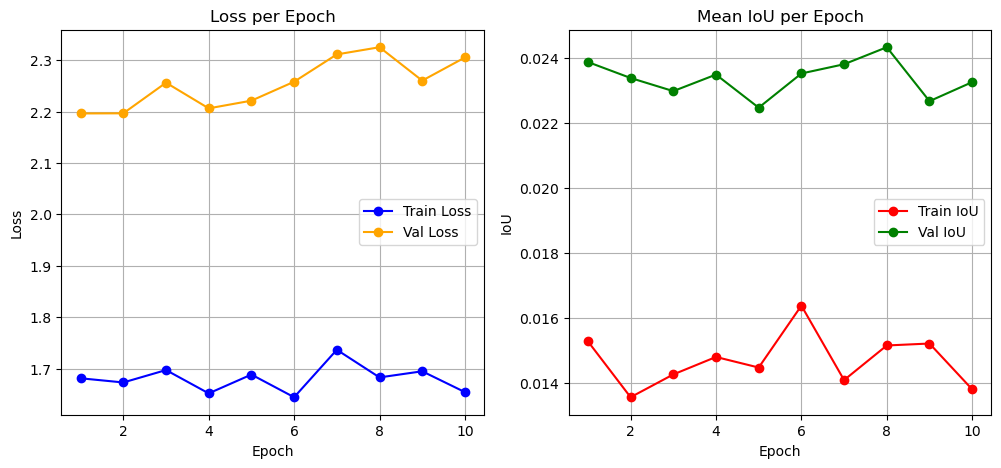

In [58]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import gc
gc.collect()
torch.cuda.empty_cache()




# Оптимизатор
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0005)

# Функция потерь (MultiBox Loss)
criterion_classification = nn.CrossEntropyLoss()


num_epochs = 10  # Количество эпох
best_loss = float("inf")  # Инициализация лучшего лосса
save_path = "best_model_mobile.pth"  # Файл для сохранения лучшей модели

train_losses, val_losses = [], []
train_ious, val_ious = [], []


for epoch in range(num_epochs):

    model.train()
    epoch_train_loss, epoch_train_iou = 0, 0
    epoch_loss = 0  
    epoch_iou = 0  
    num_batches = len(train_dataloader)
    
    progress_bar = tqdm(train_dataloader, desc=f"Эпоха {epoch+1}/{num_epochs}", leave=True)



    for images, targets in progress_bar:

        # Передаем данные на устройство
        images = torch.stack(images).to(device)

        # Инициализация меток для всех изображений в батче
        batch_labels = []
        batch_locs = []
        for target in targets:
            # Преобразуем аннотации в метки сетки 16x16
            labels, locs = get_grid_labels(image_size=(512, 512), annotations=target, grid_size=(16, 16))
            batch_labels.append(labels)
            batch_locs.append(locs)

        # Преобразуем в батч
        batch_labels = torch.stack(batch_labels).to(device)  # Метки
        batch_locs = torch.stack(batch_locs).to(device)  # Координаты объектов


        # Обработка изображения через модель
        model.train()
        optimizer.zero_grad()


        
        # Получаем предсказания (например, locs и confs)
        pred_locs, confs = model(images)

        # Потери для классификации (confs)
        confs = confs.view(-1, num_classes)  # Приводим к нужной форме
        loss_classification = F.cross_entropy(confs, batch_labels.view(-1))  # Используем flatten метки


        # Попробуем взять первые 4 предсказания (если 40 - это якоря)
        pred_locs = pred_locs[:, :4, :, :]
        # Теперь меняем формы корректно
        pred_locs = pred_locs.permute(0, 2, 3, 1).reshape(-1, 4)  # [4, 16, 16, 4] → [-1, 4]
        batch_locs = batch_locs.reshape(-1, 4)
        batch_labels = batch_labels.reshape(-1)
        # Размер изображения 
        IMG_SIZE = 512  
        # Переводим координаты в диапазон [0,1]
        pred_locs = pred_locs / IMG_SIZE
        batch_locs = batch_locs / IMG_SIZE
        pred_locs = torch.clamp(pred_locs, min=0.0, max=1.0)
        # Потери для локализации (locs)
        loss_localization = localization_loss(pred_locs, batch_locs.view(-1, 4), batch_labels.view(-1, 1).squeeze())


        lambda_loc = 1.0 # Уменьшаем влияние локализации
        loss = loss_classification + lambda_loc * loss_localization

        # Вычисляем градиенты и обновляем параметры модели
        loss.backward()
        optimizer.step()

        iou_score = calculate_iou(pred_locs.detach(), batch_locs, batch_labels)

        epoch_train_loss += loss.item()
        epoch_train_iou += iou_score

        progress_bar.set_postfix({"Train Loss": f"{loss.item():.4f}", "IoU": f"{iou_score:.4f}"})



    avg_train_loss = epoch_train_loss / num_batches
    avg_train_iou = epoch_train_iou / num_batches

    train_losses.append(avg_train_loss)
    train_ious.append(avg_train_iou)


    # Валидация
    model.eval()
    epoch_val_loss, epoch_val_iou = 0, 0
    num_val_batches = len(val_dataloader)

    with torch.no_grad():
        for images, targets in val_dataloader:
            images = torch.stack(images).to(device)
            # Инициализация меток для всех изображений в батче
            batch_labels = []
            batch_locs = []
            for target in targets:
                # Преобразуем аннотации в метки сетки 16x16
                labels, locs = get_grid_labels(image_size=(512, 512), annotations=target, grid_size=(16, 16))
                batch_labels.append(labels)
                batch_locs.append(locs)

            batch_labels = torch.stack(batch_labels).to(device)  # Метки
            batch_locs = torch.stack(batch_locs).to(device)  # Координаты объектов

            pred_locs, confs = model(images)

            confs = confs.view(-1, num_classes)  
            loss_classification = F.cross_entropy(confs, batch_labels.view(-1))  



            # Попробуем взять первые 4 предсказания (если 40 - это якоря)
            pred_locs = pred_locs[:, :4, :, :]
            # Теперь меняем формы корректно
            pred_locs = pred_locs.permute(0, 2, 3, 1).reshape(-1, 4)  # [4, 16, 16, 4] → [-1, 4]
            batch_locs = batch_locs.reshape(-1, 4)
            batch_labels = batch_labels.reshape(-1)
            # Размер изображения 
            IMG_SIZE = 512  
            # Переводим координаты в диапазон [0,1]
            pred_locs = pred_locs / IMG_SIZE
            batch_locs = batch_locs / IMG_SIZE
            pred_locs = torch.clamp(pred_locs, min=0.0, max=1.0)
            # Потери для локализации (locs)
            loss_localization = localization_loss(pred_locs, batch_locs.view(-1, 4), batch_labels.view(-1, 1).squeeze())


            loss = loss_classification + loss_localization


            iou_score = calculate_iou(pred_locs.detach(), batch_locs, batch_labels)



            epoch_val_loss += loss.item()
            epoch_val_iou += iou_score

    avg_val_loss = epoch_val_loss / num_val_batches
    avg_val_iou = epoch_val_iou / num_val_batches

    val_losses.append(avg_val_loss)
    val_ious.append(avg_val_iou)



    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Train IoU: {avg_train_iou:.4f}")
    print(f"                     Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f}")

    # Сохранение лучшей модели
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"🔥 New best model saved with val loss: {best_loss:.4f}")




print("Обучение закончено!")

# 📊 Построение графиков
plt.figure(figsize=(12, 5))

# 🔵 График лосса
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label="Train Loss", color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label="Val Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid()

# 🔴 График IoU
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_ious, marker='o', label="Train IoU", color='red')
plt.plot(range(1, num_epochs + 1), val_ious, marker='o', label="Val IoU", color='green')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Mean IoU per Epoch")
plt.legend()
plt.grid()

plt.show()

        

In [15]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()


In [38]:

def collate_fn(batch):
    images, targets = zip(*batch)  # Разбираем батч
    return list(images), list(targets)  # Оставляем списками (без stack)


In [42]:
num_epochs = 10
learning_rate = 0.001  # Скорость обучения  
weight_decay=0.0005

# Загрузка предобученной модели  
model = ssdlite320_mobilenet_v3_large(pretrained=True)  
model.to(device)  # Переводим модель на устройство  
model.train()  # Устанавливаем модель в режим обучения  

# Настройка оптимизатора  
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


model = ssdlite320_mobilenet_v3_large(pretrained=False)  # Создаём модель
model.load_state_dict(torch.load("model.pth", map_location=device))  # Загружаем веса
model.to(device);

In [30]:
for epoch in range(num_epochs):  
    total_loss = 0  
    for images, targets in data_loader:  
        images = list(image.to(device) for image in images)  
        
        # Обработка аннотаций для целевых переменных  
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]  

        # Проверка рамок на валидность  
        valid_targets = []  
        invalid_boxes = 0  

        for target in targets:  
            boxes = target['boxes'].cpu().numpy()  # Переводим на CPU для проверки  
            valid = True  
            
            for box in boxes:  
                x_min, y_min, x_max, y_max = box  
                if x_min >= x_max or y_min >= y_max:  
                    valid = False  
                    invalid_boxes += 1  
                    print(f"Invalid box found: {box}")  # Выводим информацию о неправильной рамке  
                    break  
            
            if valid:  
                valid_targets.append(target)  
            else:  
                valid_targets.append({  
                    'boxes': torch.tensor([[0, 0, 0, 0]], dtype=torch.float32).to(device),  
                    'labels': torch.tensor([0], dtype=torch.int64).to(device)  
                })  

        # Если нет валидных целей, пропускаем итерацию  
        if len(valid_targets) == 0:  
            print("No valid targets found for this batch.")  
            continue  

        # Обнуляем градиенты  
        optimizer.zero_grad()  
        
        # Прямой проход (forward pass)  
        try:  
            loss_dict = model(images, valid_targets)  
        except Exception as e:  
            print(f"Error during training: {e}")  
            continue  
            
        # Вычисляем общую потерю  
        losses = sum(loss for loss in loss_dict.values())  
        
        # Обратный проход (backward pass) и обновление весов  
        losses.backward()  
        optimizer.step()  
        
        total_loss += losses.item()  # Суммируем потери для мониторинга  

    # Печать информации о текущей эпохе  
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {total_loss / len(data_loader):.4f}")  
    
torch.save(model.state_dict(), "model.pth")
    

Epoch [1/10] Loss: 20.9586
Epoch [2/10] Loss: 22.8909
Epoch [3/10] Loss: 22.1463
Epoch [4/10] Loss: 21.5311
Epoch [5/10] Loss: 22.6307
Epoch [6/10] Loss: 22.1821
Epoch [7/10] Loss: 20.8133
Epoch [8/10] Loss: 22.3420
Epoch [9/10] Loss: 22.4242
Epoch [10/10] Loss: 23.2020



Training with SGD, Learning Rate: 0.005
Epoch [1/10] Loss: 30.6225, IoU: 0.0114
Epoch [2/10] Loss: 19.5199, IoU: 0.0148
Epoch [3/10] Loss: 19.2657, IoU: 0.0144
Epoch [4/10] Loss: 18.3271, IoU: 0.0137
Epoch [5/10] Loss: 18.6613, IoU: 0.0140
Epoch [6/10] Loss: 18.3568, IoU: 0.0133
Epoch [7/10] Loss: 17.9668, IoU: 0.0139
Epoch [8/10] Loss: 17.8307, IoU: 0.0138
Epoch [9/10] Loss: 19.0514, IoU: 0.0129
Epoch [10/10] Loss: 18.3671, IoU: 0.0134

Training with SGD, Learning Rate: 0.001
Epoch [1/10] Loss: 42.3559, IoU: 0.0098
Epoch [2/10] Loss: 24.3423, IoU: 0.0138
Epoch [3/10] Loss: 20.7459, IoU: 0.0137
Epoch [4/10] Loss: 20.0798, IoU: 0.0129
Epoch [5/10] Loss: 20.0860, IoU: 0.0128
Epoch [6/10] Loss: 18.9369, IoU: 0.0119
Epoch [7/10] Loss: 17.7089, IoU: 0.0120
Epoch [8/10] Loss: 17.7768, IoU: 0.0125
Epoch [9/10] Loss: 17.3172, IoU: 0.0122
Epoch [10/10] Loss: 17.9487, IoU: 0.0123

Training with Adam, Learning Rate: 0.005
Epoch [1/10] Loss: 23.3612, IoU: 0.0109
Epoch [2/10] Loss: 19.2903, IoU: 0

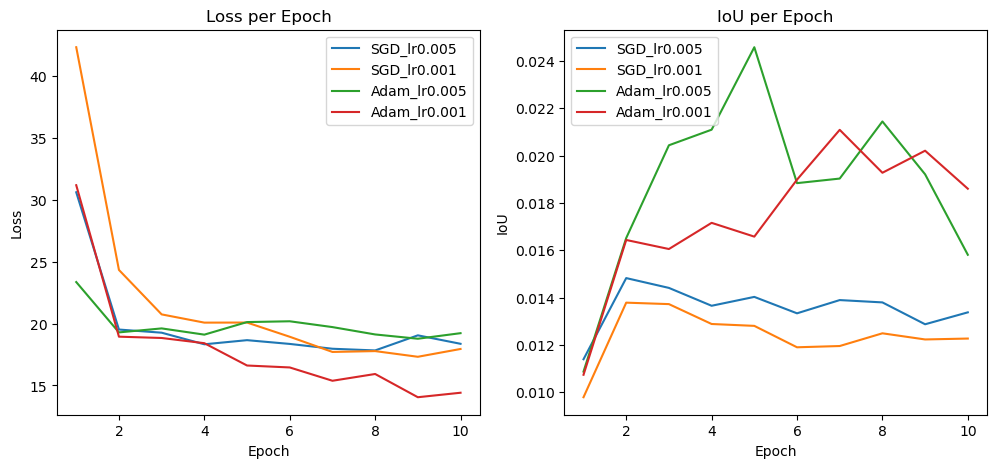

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.ops import box_iou

# Гиперпараметры для экспериментов
num_epochs = 10
learning_rates = [0.01, 0.005, 0.001]  # Разные скорости обучения
optimizers_list = ['SGD', 'Adam', "AdamW", "Adagrad", "ASGD", "Adadelta"]  # Разные оптимизаторы
momentum = 0.9
weight_decay = 0.0005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Подготовка хранения результатов
results = {}

# Функция вычисления IoU
def calculate_iou(pred_boxes, target_boxes):
    if len(pred_boxes) == 0 or len(target_boxes) == 0:
        return 0
    iou = box_iou(pred_boxes, target_boxes).mean().item()  # Среднее IoU
    return iou

# Цикл по разным параметрам
for opt_type in optimizers_list:
    for lr in learning_rates:
        print(f"\nТренировка {opt_type}, LR : {lr}")

        # Загружаем модель
        model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device)
        model.train()

        # Выбираем оптимизатор
        if opt_type == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        elif opt_type == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt_type == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt_type == "Adagrad":
            optimizer = optim.Adagrad(model.parameters(), lr=lr)
        elif opt_type == "ASGD":
            optimizer = optim.ASGD(model.parameters(), lr=lr)
        elif opt_type == "Adadelta":
            optimizer = optim.Adadelta(model.parameters(), lr=lr)


        losses_per_epoch = []
        iou_scores = []

        # Обучение модели
        for epoch in range(num_epochs):
            total_loss = 0
            total_iou = 0
            num_batches = 0

            for images, targets in data_loader:
                images = list(image.to(device) for image in images)

                # Обрабатываем аннотации (валидируем боксы)
                valid_targets = []
                for target in targets:
                    valid_targets.append({
                        'boxes': target['boxes'].to(device),
                        'labels': target['labels'].to(device)
                    })

                # Обнуляем градиенты
                optimizer.zero_grad()

                # Прямой проход
                try:
                    loss_dict = model(images, valid_targets)
                    losses = sum(loss for loss in loss_dict.values())

                    # Обратный проход
                    losses.backward()
                    optimizer.step()

                    total_loss += losses.item()
                    num_batches += 1

                    # Оценка IoU
                    with torch.no_grad():
                        model.eval()
                        output = model(images)  # Получаем предсказания
                        model.train()

                        for i, out in enumerate(output):
                            pred_boxes = out['boxes'].detach()
                            target_boxes = valid_targets[i]['boxes'].detach()

                            iou = calculate_iou(pred_boxes, target_boxes)
                            total_iou += iou

                except Exception as e:
                    print(f"Error during training: {e}")
                    continue

            avg_loss = total_loss / num_batches
            avg_iou = total_iou / num_batches
            losses_per_epoch.append(avg_loss)
            iou_scores.append(avg_iou)

            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")

        # Сохраняем результаты
        results[f"{opt_type}_lr{lr}"] = (losses_per_epoch, iou_scores)

# Визуализация графиков
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
for key, (losses, _) in results.items():
    plt.plot(range(1, num_epochs + 1), losses, label=key)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# График IoU
plt.subplot(1, 2, 2)
for key, (_, ious) in results.items():
    plt.plot(range(1, num_epochs + 1), ious, label=key)
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()

plt.show()


In [96]:
torch.save(model.state_dict(), "model.pth")


In [97]:
import torch
from torchvision.transforms import functional as F
from torchvision.models.detection import ssdlite320_mobilenet_v3_large

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ssdlite320_mobilenet_v3_large(pretrained=False)  # Создаём модель
model.load_state_dict(torch.load("model.pth", map_location=device))  # Загружаем веса
model.to(device)
model.eval() 


SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [101]:
from PIL import Image
import matplotlib.pyplot as plt

# Загружаем изображение
image_path = "/home/maksim/develops/python/devsTraining/zala_task/dataset/image/100.jpg"
image = Image.open(image_path).convert("RGB")

# Преобразуем изображение в тензор
image_tensor = F.to_tensor(image).unsqueeze(0).to(device)  # (1, C, H, W)
# Получаем предсказания
with torch.no_grad():
    predictions = model(image_tensor)

# Извлекаем боксы и оценки достоверности
boxes = predictions[0]["boxes"].cpu().numpy()  # Координаты боксов
scores = predictions[0]["scores"].cpu().numpy()  # Уверенность модели

# Фильтруем боксы по порогу уверенности 
threshold = 0.1
filtered_boxes = boxes[scores > threshold]


In [99]:
predictions

[{'boxes': tensor([[1981.0000, 1816.0000, 1981.0000, 1816.0000],
          [1981.0000, 1816.0000, 1981.0000, 1816.0000],
          [1403.6481, 1816.0000, 1632.2502, 1816.0000],
          ...,
          [ 202.7652,  797.5691,  498.0046, 1128.2605],
          [ 896.1140, 1069.9753, 1191.3517, 1400.6432],
          [ 400.8791,  616.0085,  696.0936,  946.6313]], device='cuda:0'),
  'scores': tensor([0.2744, 0.2310, 0.1078, 0.1076, 0.1075, 0.1052, 0.1029, 0.1014, 0.1006,
          0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0998,
          0.0995, 0.0995, 0.0995, 0.0994, 0.0994, 0.0993, 0.0993, 0.0980, 0.0893,
          0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893,
          0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0871, 0.0869,
          0.0858, 0.0844, 0.0830, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823,
          0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823,
          0.0821, 0.0821, 0.0821, 0.0

TypeError: Image data of dtype <U32 cannot be converted to float

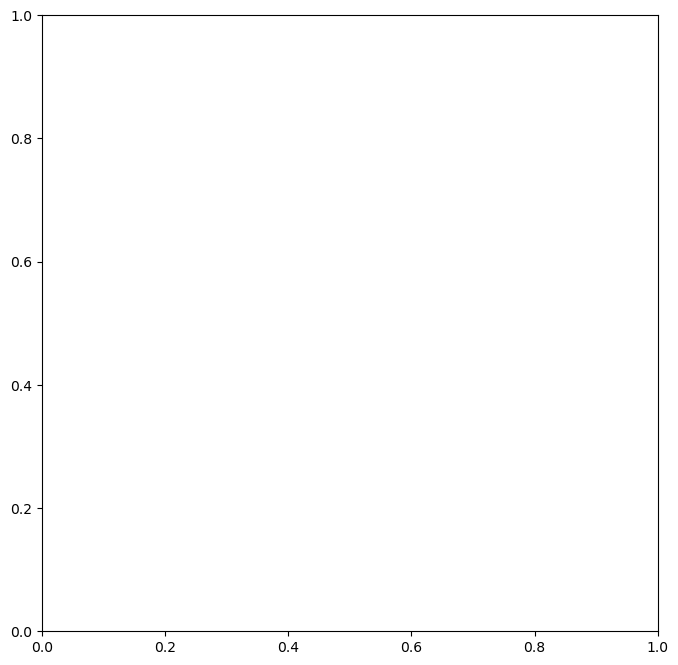

In [12]:
import matplotlib.patches as patches

# Отображаем изображение
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(image)

# Добавляем боксы
for box in filtered_boxes:
    x_min, y_min, x_max, y_max = box
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(rect)
    print(x_min, y_min, x_max, y_max)
plt.show()


## АНАЛИЗ МОДЕЛИ

In [19]:
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Загружаем предобученную модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device)

# Переключаем в режим инференса (обязательно!)
model.eval()

# Создаем тестовый ввод размером (batch_size=1, channels=3, height=320, width=320)
input_tensor = torch.randn(1, 3, 320, 320).to(device)

# Считаем количество операций
flops = FlopCountAnalysis(model, input_tensor)

# Выводим результаты
print(f"Total GFlops: {flops.total() / 1e9:.2f} GFlops")
print(parameter_count_table(model))  # Выводит количество параметров модели


Unsupported operator aten::sub encountered 9 time(s)
Unsupported operator aten::div encountered 21 time(s)
Unsupported operator aten::ceil encountered 2 time(s)
Unsupported operator aten::mul encountered 32 time(s)
Unsupported operator aten::pad encountered 1 time(s)
Unsupported operator aten::hardswish_ encountered 20 time(s)
Unsupported operator aten::add_ encountered 10 time(s)
Unsupported operator aten::hardsigmoid encountered 8 time(s)
Unsupported operator aten::hardtanh_ encountered 24 time(s)
Unsupported operator aten::add encountered 19 time(s)
Unsupported operator aten::meshgrid encountered 6 time(s)
Unsupported operator aten::repeat encountered 6 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::exp encountered 2 time(s)
Unsupported operator aten::min encountered 92 time(s)
Unsupported operator aten::_shape_as_tensor encountered 90 time(s)
Unsupported operator aten::topk encountered 90 time(s)
Unsupported operator prim::CallFunction e

Total GFlops: 0.60 GFlops
| name                                    | #elements or shape   |
|:----------------------------------------|:---------------------|
| model                                   | 3.4M                 |
|  backbone                               |  2.1M                |
|   backbone.features                     |   1.6M               |
|    backbone.features.0                  |    0.9M              |
|    backbone.features.1                  |    0.8M              |
|   backbone.extra                        |   0.5M               |
|    backbone.extra.0                     |    0.3M              |
|    backbone.extra.1                     |    0.1M              |
|    backbone.extra.2                     |    67.7K             |
|    backbone.extra.3                     |    25.7K             |
|  head                                   |  1.4M                |
|   head.classification_head              |   1.3M               |
|    head.classification_head.module

In [6]:
import torch  
from torchvision.models.detection import ssdlite320_mobilenet_v3_large  
from torchprofile import profile_macs  

# Загрузка модели  
device = "cpu" 
model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device)  

# Установка модели в режим оценки, отключение градиентов  
model.eval()  

# Создание тестового входного тензора  
input_tensor = torch.randn(1, 3, 512, 512).to(device)  

# Профилирование модели для подсчета MACs  
macs = profile_macs(model, input_tensor)  
gflops = macs / 1e9  # переведение в GFLOPs  
 
device = "cuda" 
macs = profile_macs(model, input_tensor)  
gflops = macs / 1e9  # переведение в GFLOPs  

print(f"GFLOPs на Cuda: {gflops:.2f}")

print(f"GFLOPs на CPU: {gflops:.2f}")  

GFLOPs на Cuda: 0.60
GFLOPs на CPU: 0.60


In [8]:
import torch  
import torch.nn as nn  
from torchvision.models.detection import ssdlite320_mobilenet_v3_large  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device)  

# Параметры входных данных  
input_tensor = torch.randn(1, 3, 320, 320).to(device)  # 1 изображение размером 320x320  

# Первая отправка через модель для проверки выходных данных  
model.eval()  # Установка в режим оценки  
with torch.no_grad():  # Отключаем градиенты  
    output = model(input_tensor)  

# Вывод информации о выходах  
print("Output:", output)  # Вывод информации о выходах  

# Вывод параметров модели  
print("Total parameters:", sum(p.numel() for p in model.parameters()))  
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))  


Output: [{'boxes': tensor([[ 10.8309,   9.2505, 293.9546, 318.4692],
        [ 10.1021,   6.6071, 292.0480, 318.9286],
        [ 11.2432,  28.1390, 290.2533, 318.2936],
        ...,
        [101.6973,  34.4321, 172.2271,  75.1670],
        [222.9227,  19.3669, 317.9391, 246.8920],
        [263.9545, 143.1682, 319.4971, 217.5221]], device='cuda:0'), 'scores': tensor([0.2876, 0.1966, 0.1437, 0.0929, 0.0690, 0.0639, 0.0632, 0.0575, 0.0568,
        0.0549, 0.0538, 0.0525, 0.0524, 0.0522, 0.0509, 0.0501, 0.0498, 0.0496,
        0.0491, 0.0487, 0.0479, 0.0475, 0.0470, 0.0463, 0.0458, 0.0443, 0.0439,
        0.0437, 0.0432, 0.0430, 0.0429, 0.0428, 0.0426, 0.0424, 0.0422, 0.0406,
        0.0406, 0.0406, 0.0401, 0.0400, 0.0395, 0.0394, 0.0391, 0.0390, 0.0389,
        0.0388, 0.0387, 0.0383, 0.0382, 0.0382, 0.0378, 0.0377, 0.0369, 0.0368,
        0.0362, 0.0360, 0.0357, 0.0351, 0.0350, 0.0349, 0.0349, 0.0348, 0.0347,
        0.0343, 0.0338, 0.0337, 0.0337, 0.0333, 0.0332, 0.0332, 0.0330, 0.0330,

In [10]:
model

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert